In [ ]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, Flatten, MaxPooling2D, AveragePooling2D


##**Loading and Preprocessing dataset**

In [ ]:
wdir = '/content/drive/My Drive/project/images'
mnist = '/content/mnist_784.csv'

dataset = []

In [ ]:
# Data from mnist dataset (50000 examples)
df = pd.read_csv(mnist, header=None, nrows=50000, skiprows=1)
df.dropna(axis=1)
data = df.to_numpy(dtype='float32')
examples = data.shape[0]
feature = data[:,:-1].reshape(examples, 28, 28)
label = data[:,-1]
for example in range(examples):
    f = feature[example]
    l = label[example].astype('int')
    dataset.append([f, l])

In [ ]:
print(len(dataset))
print(examples)

50000
50000


In [ ]:
# Data from web scraped folder in project drive (1027 examples)
for i in range(10):
    path = os.path.join(wdir, str(i))
    for img in os.listdir(path):
        array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resize_array = cv2.resize(array, (28,28))
        dataset.append([resize_array, i])

random.shuffle(dataset)

In [ ]:
X = []
Y = []
for features, labels in dataset:
    X.append(features)
    Y.append(labels)

#Reshaping of features(m, nx, nx, 1) and labels(m, 1)
X = np.array(X).reshape(-1, 28, 28, 1).astype('float32')
y = tf.one_hot(Y, depth=10)

#Training and test sets
X_train = X[:(len(dataset)-200),:,:,:]
X_test = X[(len(dataset)-200):,:,:,:]
y_train = y[:(len(dataset)-200),:]
y_test = y[(len(dataset)-200):,:]

In [ ]:
print(X_test[11].shape)

(28, 28, 1)


In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
print(y_test[11])

tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


##**Building the Model**

In [ ]:
 model = Sequential()
    
 model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:]))
 model.add(BatchNormalization(axis=3))
 model.add(Activation('relu'))
 model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
 model.add(Conv2D(64, (3,3), padding='valid'))
 model.add(BatchNormalization(axis=3))
 model.add(Activation('relu'))
 model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))
    
 model.add(Conv2D(64, (3,3)))
 model.add(BatchNormalization(axis=3))
 model.add(Activation('relu'))
 model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    
 model.add(Flatten())
 model.add(Dense(50))
 model.add(Dense(10, activation='softmax'))
    
 model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=256, validation_split=0.12, epochs=5)

Epoch 1/5
176/176 [==============================] - 83s 473ms/step - loss: 0.2479 - accuracy: 0.9286 - val_loss: 4.6347 - val_accuracy: 0.1168
Epoch 2/5
176/176 [==============================] - 82s 468ms/step - loss: 0.0799 - accuracy: 0.9748 - val_loss: 2.4026 - val_accuracy: 0.4010
Epoch 3/5
176/176 [==============================] - 82s 466ms/step - loss: 0.0597 - accuracy: 0.9810 - val_loss: 0.3364 - val_accuracy: 0.8954
Epoch 4/5
176/176 [==============================] - 82s 465ms/step - loss: 0.0467 - accuracy: 0.9848 - val_loss: 0.1238 - val_accuracy: 0.9602
Epoch 5/5
176/176 [==============================] - 86s 487ms/step - loss: 0.0371 - accuracy: 0.9884 - val_loss: 0.0670 - val_accuracy: 0.9773


In [ ]:
saved_model = model.to_json()
with open('model.json', 'w') as file:
  file.write(saved_model)
model.save_weights('weights.h5')

##Testing data using test_set
 

In [ ]:
pred = model.evaluate(X_test, y_test)

print('loss = ' + str(pred[0]) )
print('Accuracy = ' + str(pred[1]))

7/7 [==============================] - 0s 14ms/step - loss: 0.0522 - accuracy: 0.9900
loss = 0.0522134006023407
Accuracy = 0.9900000095367432


tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


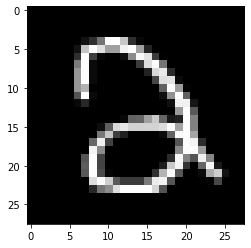

In [ ]:
plt.imshow(X_test[34].reshape(28,28), cmap='gray')
print(y_test[34])

##Predicting Handwritten digits written in Paint
 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


In [ ]:
index = 199
prediction = np.zeros((1,10), dtype=float)
test_photo = '/content/sample_17.png'
array = cv2.imread(test_photo, cv2.IMREAD_GRAYSCALE)
resize_array = cv2.resize(array, (28,28))
resize_array = np.array(resize_array).reshape(-1, 28, 28, 1).astype('float32')/255
prediction = model.predict(resize_array)
digit = np.argmax(prediction)

Predicted digit = 7
[[1.5773039e-05 8.7787128e-05 1.4500156e-05 1.7289800e-04 1.0379846e-05
  3.1446431e-05 7.4064670e-09 9.9077177e-01 7.5309770e-05 8.8201016e-03]]


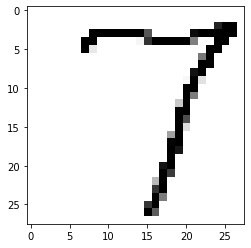

In [ ]:
print('Predicted digit = ' + str(digit))
plt.imshow(resize_array.reshape(28,28), cmap='gray')
print(prediction)